In [4]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [6]:
train=pd.read_csv("C:/Users/ricar/OneDrive/Documents/5th Year - HonoursMasters/COS 711/Assignment 3/Train.csv")
test=pd.read_csv("C:/Users/ricar/OneDrive/Documents/5th Year - HonoursMasters/COS 711/Assignment 3/Test.csv")

# split train dataset into train \ test : 75% \ 25%
train = train[:11654:]
test = train[:3885]

train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [7]:
def replace_data(ts):
    ts = ts.replace("nan","-100").split(",")  # NANs replaced with value differnt from all input values
    replaced_ts = np.array([float(t) for t in ts])
    return replaced_ts

def extract_time_series(df, feat_name):
    return np.array(df[feat_name].apply(lambda ts: replace_data(ts)).tolist())

import matplotlib.pyplot as plt
for i in range(len(train)):
    if train['location'][i] == 'A':
        train['location'][i] = 0
    elif train['location'][i] == 'B':
        train['location'][i] = 1
    elif train['location'][i] == 'C':
        train['location'][i] = 2
    elif train['location'][i] == 'D':
        train['location'][i] = 3
    elif train['location'][i] == 'E':
        train['location'][i] = 4
        
feat_name_arr = ['temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd', 'atmos_press']

# Transform training data
train_time_series_feat = np.array([extract_time_series(train, feat_name) for feat_name in feat_name_arr]).transpose(1,2,0)
print('Shape of training data:', train_time_series_feat.shape)

# Transform test data
test_time_series_feat = np.array([extract_time_series(test, feat_name) for feat_name in feat_name_arr]).transpose(1,2,0)
print('Shape of test data:', test_time_series_feat.shape)

D:\Anaconda Installation\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda Installation\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda Installation\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda Installation\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A valu

Shape of training data: (11654, 121, 6)
Shape of test data: (3885, 121, 6)


#### Normalization

In [8]:
time_series_feat = np.concatenate([train_time_series_feat, test_time_series_feat], axis = 0)

# data standardization
for c in range(time_series_feat.shape[2]):
    valid_idx = np.where(time_series_feat[:,:,c] != -100) # doesn't include missing values
    mean = time_series_feat[:,:,c][valid_idx].mean()
    std = time_series_feat[:,:,c][valid_idx].std()
    
    time_series_feat[:,:,c][valid_idx] -= mean
    time_series_feat[:,:,c][valid_idx] /= std

train_time_series_feat = time_series_feat[:train['location'].shape[0]]
test_time_series_feat = time_series_feat[train['location'].shape[0]:]

train_X = train_time_series_feat.reshape(-1,121,6,1)
test_X = test_time_series_feat.reshape(-1,121,6,1)
train_X.shape, test_X.shape

((11654, 121, 6, 1), (3885, 121, 6, 1))

#### Splitting Train set into train and validation

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train['target'], test_size=0.2, random_state=13)

train_X = train_X.reshape(train_X.shape[0],1, train_X.shape[1],train_X.shape[2],train_X.shape[3])
valid_X = valid_X.reshape(valid_X.shape[0],1, valid_X.shape[1],valid_X.shape[2],valid_X.shape[3])
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((9323, 1, 121, 6, 1), (2331, 1, 121, 6, 1), (9323,), (2331,))

### CNN-LSTM

In [11]:
# CNN MODEL ###############
batch_size = 32
epochs = 50
num_classes = 1

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(4, 4), activation='relu',input_shape=(121,6,1),padding='same'))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))               
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.5))
fashion_model.add(Flatten())
fashion_model.compile(optimizer='adam',loss='mse')
fashion_model.summary()

## LSTM MODEL #######
model = Sequential()
model.add(TimeDistributed(fashion_model, input_shape=(None,121,6,1)))
model.add(LSTM(64, activation='relu', dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(6,121)))
model.add(LSTM(64, activation='relu', dropout=0.3, recurrent_dropout=0.2,))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss ='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 6, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 3, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 3, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 3, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 2, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3968)            

In [12]:
model_train = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 9323 samples, validate on 2331 samples
Epoch 1/50
9323/9323 [==============================] - 20s 2ms/step - loss: 32.3356 - mse: 2549.5161 - val_loss: 27.3469 - val_mse: 2144.8718
Epoch 2/50
9323/9323 [==============================] - 2s 257us/step - loss: 26.7720 - mse: 1901.9423 - val_loss: 25.8958 - val_mse: 1947.9438
Epoch 3/50
9323/9323 [==============================] - 2s 258us/step - loss: 25.7589 - mse: 1732.0543 - val_loss: 26.6737 - val_mse: 1939.2145
Epoch 4/50
9323/9323 [==============================] - 2s 260us/step - loss: 24.4881 - mse: 1587.1196 - val_loss: 31.3257 - val_mse: 2395.4800
Epoch 5/50
9323/9323 [==============================] - 2s 262us/step - loss: 24.2339 - mse: 1530.7412 - val_loss: 26.7507 - val_mse: 1953.1952
Epoch 6/50
9323/9323 [==============================] - 2s 268us/step - loss: 23.8130 - mse: 1490.6815 - val_loss: 28.5212 - val_mse: 2043

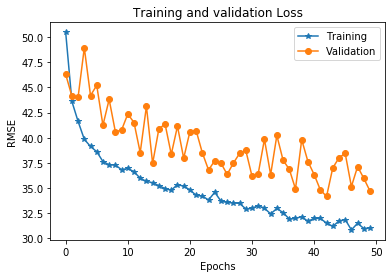

In [14]:
loss = model_train.history['mse']
val_loss = model_train.history['val_mse']

mse_loss = np.sqrt(loss)
mse_val_loss = np.sqrt(val_loss)
plt.figure(1)
plt.plot(np.arange(epochs), mse_loss, '*-', label = 'Training')
plt.plot(np.arange(epochs), mse_val_loss, 'o-', label = 'Validation')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

### Model Evaluation on Test Set

In [15]:
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1], test_X.shape[2],1)

In [16]:
test_eval = model.evaluate(test_X, test['target'], verbose=1)
print('RMSE of Test',np.sqrt(test_eval))

3885/3885 [==============================] - 0s 82us/step
RMSE of Test [ 4.36646196 31.36590323]


### Prediction

In [299]:
y_pred = model.predict(test_X)

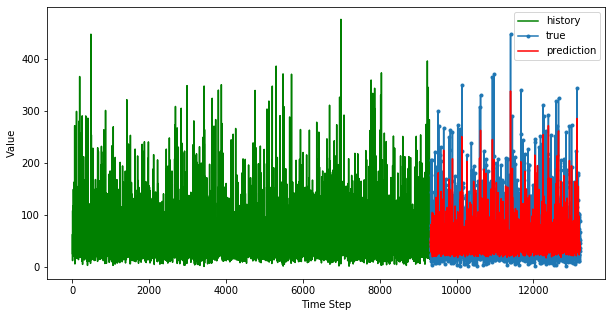

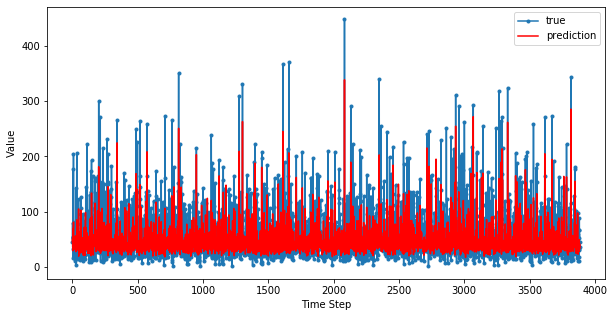

In [300]:
plt.figure(1, figsize = (10,5))
plt.plot(np.arange(0, len(train_label)),train_label, 'g', label="history")
plt.plot(np.arange(len(train_label), len(train_label) + len(test['target'])), test['target'], marker='.', label="true")
plt.plot(np.arange(len(train_label), len(train_label) + len(test['target'])), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

plt.figure(2, figsize = (10,5))
plt.plot(test['target'], marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()